<a href="https://colab.research.google.com/github/jungmin0710/K-digital-PythonDeepLearning/blob/main/Word2Vec_CPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Korean Word2Vec
네이버 영화 리뷰 데이터


In [1]:
import warnings 
warnings.filterwarnings('ignore')

## 1.Install & Import Packages
* Install KoNLPy

In [2]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 460kB 34.7MB/s 
     |████████████████████████████████| 92kB 8.1MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


* Import Packages

In [3]:
import pandas as pd
import matplotlib.pyplot as plt


## 2.Data Preprocessing

### 1)naverRatings.zip
* Google Drive Mount

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/datasets/naverRatings.zip

-rw------- 1 root root 7903524 Mar 31 02:11 '/content/drive/My Drive/Colab Notebooks/datasets/naverRatings.zip'


In [6]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/naverRatings.zip

Archive:  /content/drive/My Drive/Colab Notebooks/datasets/naverRatings.zip
  inflating: naverRatings.txt        


In [7]:
!ls -l naverRatings.txt

-rw-r--r-- 1 root root 19515078 May  4  2020 naverRatings.txt


### 2) 데이터 읽어오기
* Label : '1'(긍정), '0'(부정)

In [8]:
train_data = pd.read_table('naverRatings.txt') 

train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


* 네이버 영화 리뷰 개수

In [9]:
print(len(train_data))

200000


### 3) 데이터 정제(Cleaning)
* NULL값 존재 확인

In [10]:
print(train_data.isnull().values.any())

True


* NULL값 존재 행 제거 후 재확인

In [11]:
train_data = train_data.dropna(how = 'any') 

print(train_data.isnull().values.any())

False


* NULL값 제거 후 데이터 개수

In [12]:
print(len(train_data))

199992


### 4) 정규표현식을 통한 한글 외 문자 제거

In [13]:
train_data['document'] = train_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')

* 처리 결과 확인

In [14]:
train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [15]:
train_data['document'].shape

(199992,)

### 5) 불용어(Stopword) 지정

In [16]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍', '과','도','를','으로','자','에','와','한','하다']

### 6) Okt( )를 활용한 토큰화 및 불용어 제거

In [17]:
%%time

from konlpy.tag import Okt

okt = Okt()
tokenized_data = []

for sentence in train_data['document']:
  temp_X = okt.morphs(sentence,
                      stem = True)
  temp_X = [word for word in temp_X if not word in stopwords]
  tokenized_data.append(temp_X)

CPU times: user 7min 26s, sys: 1.76 s, total: 7min 28s
Wall time: 7min 15s


In [18]:
len(tokenized_data)

199992

## 3.리뷰 데이터 분포 시각화

### 1) 리뷰 길이 확인

In [19]:
print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data)) 
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


### 2) 리뷰 길이 시각화

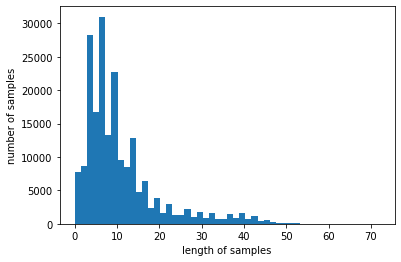

In [20]:
plt.hist([len(s) for s in tokenized_data], bins = 50) 
plt.xlabel('length of samples') 
plt.ylabel('number of samples') 
plt.show()

## 4.Word2Vec 수행

### 1) 임베딩 학습
* Vector 차원 : 100 
* Window 크기 : 5 
* size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원. 
* window = 컨텍스트 윈도우 크기 
* min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.) 
* workers = 학습을 위한 프로세스 수 
* sg = 0은 CBOW, 1은 Skip-gram

In [21]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, 
                 size = 100, 
                 window = 5, 
                 min_count = 5, 
                 workers = 4, 
                 sg = 1)

### 2) 학습된 임베딩 매트릭스 크기 확인

In [22]:
model.wv.vectors.shape

(16477, 100)

## 5.임베딩 결과 테스트

In [23]:
model.wv.most_similar('이병헌')

[('정려원', 0.8157336711883545),
 ('최수종', 0.8139446973800659),
 ('유다인', 0.809329628944397),
 ('심은하', 0.8023520112037659),
 ('안성기', 0.7928484678268433),
 ('양동근', 0.7926052808761597),
 ('채민서', 0.791305422782898),
 ('샤룩', 0.7906743288040161),
 ('혼신', 0.7866038680076599),
 ('김승우', 0.7864974737167358)]

In [24]:
model.wv.most_similar('액션')

[('액션씬', 0.7293186187744141),
 ('디도', 0.7227051258087158),
 ('격투', 0.720159649848938),
 ('무술', 0.7179709672927856),
 ('총격', 0.710495114326477),
 ('격투씬', 0.7075188755989075),
 ('레이싱', 0.6983073353767395),
 ('액션영화', 0.6946488618850708),
 ('스릴러물', 0.6874148845672607),
 ('추격', 0.6847896575927734)]

In [33]:
model.wv.most_similar('공리')

[('공리계', 0.750770092010498),
 ('명제', 0.6549944877624512),
 ('연산자', 0.6441450715065002),
 ('공준', 0.6226961612701416),
 ('복소수', 0.6169536113739014),
 ('도함수', 0.6159658432006836),
 ('범주', 0.6145826578140259),
 ('집합론', 0.6102553606033325),
 ('논리', 0.6040921807289124),
 ('술어', 0.5986670255661011)]

In [37]:
model.wv.most_similar('리듬')

[('음색', 0.683139443397522),
 ('선율', 0.671829104423523),
 ('창법', 0.6605373024940491),
 ('멜로디', 0.6571379899978638),
 ('울림', 0.63868248462677),
 ('어쿠스틱', 0.6160341501235962),
 ('저음', 0.5951864719390869),
 ('건반', 0.5927807688713074),
 ('드럼', 0.583595871925354),
 ('댄스', 0.5775110721588135)]

## 6.사전훈련된 Word2Vec

### 1) Google Drive Mount

In [25]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/datasets/ko_w2v.zip

-rw------- 1 root root 80596565 Mar 31 02:15 '/content/drive/My Drive/Colab Notebooks/datasets/ko_w2v.zip'


### 2) Unzip 'ko_w2v.zip'

In [27]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/ko_w2v.zip

Archive:  /content/drive/My Drive/Colab Notebooks/datasets/ko_w2v.zip
  inflating: ko.bin                  
  inflating: ko.tsv                  


In [28]:
!ls -l ko.bin

-rw------- 1 root root 50697568 Dec 21  2016 ko.bin


### 3) Word2Vec 가져오기

In [29]:
import gensim

In [30]:
model = gensim.models.Word2Vec.load('ko.bin')

### 4) Word2Vec Test

In [31]:
model.wv.most_similar('금융')

[('감독원', 0.6556380391120911),
 ('신용', 0.6269841194152832),
 ('은행', 0.6236893534660339),
 ('외환', 0.6192121505737305),
 ('중소기업', 0.6051731705665588),
 ('중앙은행', 0.6050782799720764),
 ('증권', 0.5907014608383179),
 ('거래', 0.5898198485374451),
 ('투자', 0.5844753384590149),
 ('경영', 0.5692520141601562)]

In [32]:
model.wv.most_similar('은행')

[('씨티', 0.6328796148300171),
 ('금융', 0.6236892938613892),
 ('농협', 0.6008170247077942),
 ('본점', 0.5930641889572144),
 ('한국은행', 0.5903059840202332),
 ('지점장', 0.5847948789596558),
 ('은행장', 0.5830198526382446),
 ('거래소', 0.5792121887207031),
 ('증권', 0.5775279998779297),
 ('외환', 0.5623738765716553)]

In [38]:
model.wv.most_similar('쿠키')

[('브레드', 0.6969012022018433),
 ('민트', 0.6922163367271423),
 ('케이크', 0.6763652563095093),
 ('에스프레소', 0.6717720031738281),
 ('아이스크림', 0.6696140766143799),
 ('요구르트', 0.6631724834442139),
 ('비스킷', 0.660405158996582),
 ('밀크', 0.657418966293335),
 ('샌드위치', 0.6537575125694275),
 ('버터', 0.6517305374145508)]

In [39]:
model.wv.most_similar('주식')

[('지분', 0.6598864197731018),
 ('증권', 0.6218825578689575),
 ('사채', 0.6179963946342468),
 ('자본금', 0.6030240058898926),
 ('현물', 0.5963727235794067),
 ('주주', 0.5927849411964417),
 ('코스닥', 0.5803253650665283),
 ('모회사', 0.5793282985687256),
 ('상장', 0.5687190890312195),
 ('어음', 0.5640697479248047)]

In [40]:
model.wv.most_similar('인공지능')

[('컴퓨팅', 0.6520194411277771),
 ('가상현실', 0.6393702030181885),
 ('심리학', 0.63037109375),
 ('모델링', 0.625065267086029),
 ('신경망', 0.6200424432754517),
 ('로봇', 0.6109743118286133),
 ('시뮬레이션', 0.6101070642471313),
 ('지능', 0.6092983484268188),
 ('기술', 0.6087720990180969),
 ('기술인', 0.5957075953483582)]

본 내용은 2021/03/31(수)에 학습한 내용입니다.